In [1]:
%matplotlib inline

from data_preparation import DataPreparation
from normalisation import LOBNormaliser

import os
import datetime

import keras
import numpy as np
from keras import optimizers
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

The output folder already exists for currency BTC-USD, not running snapshot generation
Took to finish: 
0.046174049377441406
Saved 0 snapshots
Total number of updates processeperford: 0


Using TensorFlow backend.


## Defining parameters for the running pipeline
Currently every parameter is defined in this cell.

The DataPreparation does not re-run the snapshot generation if the target folder already exists.

In [2]:
SNAPSHOT_GAP_SECONDS = 5
LOB_DEPTH = 40

BATCH_SIZE = 25
LABELS_LOOKAHEAD = 20

BIN_START = -25
BIN_END = -23
BIN_STEP = 0.0002
IS_LOG = True

NR_OF_BINS = 50

LOG_BASE = 1.2

# Target folders
RAW_DATA_FOLDER = '/home/ralph/dev/smartlab/data/raw2/'
SNAPSHOTS_OUTPUT_FOLDER = os.path.join('/home/ralph/dev/smartlab/data/snapshots/', 'depth-' + str(LOB_DEPTH))
NORMALISATION_OUTPUT_FOLDER = '/home/ralph/dev/smartlab/data/normalised_JSON/depth-' + str(LOB_DEPTH)

START_DATE = datetime.datetime.strptime('2020-04-04', "%Y-%m-%d")
END_DATE = datetime.datetime.strptime('2020-04-06', "%Y-%m-%d")

# Preparing and normalising data

In [15]:
data_preparator = DataPreparation(True, SNAPSHOT_GAP_SECONDS, LOB_DEPTH, LOB_DEPTH * 16)
data_preparator.create_snapshots(START_DATE, END_DATE, RAW_DATA_FOLDER, SNAPSHOTS_OUTPUT_FOLDER)

Parsing  XRP-USD  - from  2020-04-04 00:00:00
Parsing  .directory  - from  2020-04-04 00:00:00
Parsing  BTC-EUR  - from  2020-04-04 00:00:00
The output folder already exists for currency BTC-USD, not running snapshot generation


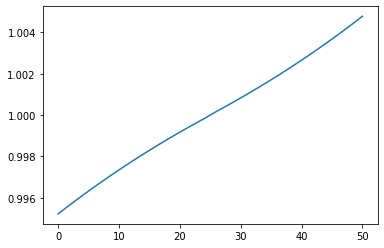

Opening snapshot file:  2020-04-05_0.npy
Nr. of total snapshots in file : 83623 - dividing into 14 chunks
Saving normalised batch to  /home/ralph/dev/smartlab/data/normalised_JSON/depth-40/linear-0.0002-50_bins/BTC-USD/2020-04-05_0-normalised-0.npy
Saving normalised batch to  /home/ralph/dev/smartlab/data/normalised_JSON/depth-40/linear-0.0002-50_bins/BTC-USD/2020-04-05_0-normalised-1.npy
Saving normalised batch to  /home/ralph/dev/smartlab/data/normalised_JSON/depth-40/linear-0.0002-50_bins/BTC-USD/2020-04-05_0-normalised-2.npy
Saving normalised batch to  /home/ralph/dev/smartlab/data/normalised_JSON/depth-40/linear-0.0002-50_bins/BTC-USD/2020-04-05_0-normalised-3.npy
Saving normalised batch to  /home/ralph/dev/smartlab/data/normalised_JSON/depth-40/linear-0.0002-50_bins/BTC-USD/2020-04-05_0-normalised-4.npy
Saving normalised batch to  /home/ralph/dev/smartlab/data/normalised_JSON/depth-40/linear-0.0002-50_bins/BTC-USD/2020-04-05_0-normalised-5.npy
Saving normalised batch to  /home/ra

In [5]:
normaliser = LOBNormaliser(LOB_DEPTH, IS_LOG, BIN_START, BIN_END, LOG_BASE, NR_OF_BINS, BATCH_SIZE, BIN_STEP)
normaliser.run(SNAPSHOTS_OUTPUT_FOLDER, NORMALISATION_OUTPUT_FOLDER)

In [20]:
# %%


all_input = np.empty((0, BATCH_SIZE, NR_OF_BINS))
all_labels = np.empty((0))

for j in range(0, 14):
    curr_input = np.load(os.path.join(NORMALISATION_OUTPUT_FOLDER, 'linear-' + str(BIN_STEP) + '-' + str(NR_OF_BINS) + '_bins', 'BTC-USD/2020-04-05_0-normalised-' + str(j) + '.npy'))
    curr_mid_prices = np.load(os.path.join(NORMALISATION_OUTPUT_FOLDER, 'linear-' + str(BIN_STEP) + '-' + str(NR_OF_BINS) + '_bins', 'BTC-USD/2020-04-05_0-mid_price-' + str(j) + '.npy'))

    labels = []
    for i in range(0, len(curr_input) - LABELS_LOOKAHEAD):
        current_mid_price = curr_mid_prices[i]
        next_n_prices = curr_mid_prices[i + 1:i + 1 + LABELS_LOOKAHEAD]
        if current_mid_price < np.average(next_n_prices):
            labels.append(1)
        else:
            labels.append(0)
    labels = np.array(labels)
    reshaped_input = curr_input.reshape((curr_input.shape[0], BATCH_SIZE, NR_OF_BINS))[:-LABELS_LOOKAHEAD]
    all_input = np.concatenate([all_input, reshaped_input])
    all_labels = np.concatenate([all_labels, labels])

In [21]:
all_input[290]

array([[36.62825221, 36.62825221, 36.62825221, ..., 50.85037676,
        50.85037676, 50.85037676],
       [45.89307731, 45.89307731, 45.89307731, ..., 67.0619123 ,
        67.0619123 , 67.0619123 ],
       [25.57641999, 25.57641999, 25.57641999, ..., 58.77526274,
        58.77526274, 58.77526274],
       ...,
       [37.96600138, 37.96600138, 37.96600138, ..., 50.99235326,
        50.99235326, 50.99235326],
       [29.46431047, 29.46431047, 29.46431047, ..., 50.71369544,
        50.71369544, 50.71369544],
       [38.88778511, 38.88778511, 38.88778511, ..., 50.72233256,
        50.72233256, 50.72233256]])

# Displaying a single batch

We have used single a single batch in this example, which is displayed.

Note that the center of a row is always 'darker' - the volume available here is always less, and always should be growing as the sides of the diagram is reached (the color gets lighter).

(18886, 25, 50)


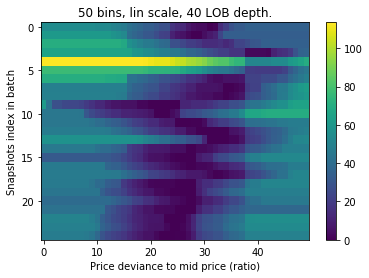

In [22]:
print(all_input.shape)
fig, ax = plt.subplots()

plt.title(str(NR_OF_BINS) + ' bins, lin scale, ' + str(LOB_DEPTH) + ' LOB depth.')
plt.imshow(all_input[0], aspect='auto')
plt.xlabel('Price deviance to mid price (ratio)')
plt.ylabel('Snapshots index in batch')
plt.colorbar()
plt.show()

In [23]:
# Animation of batches

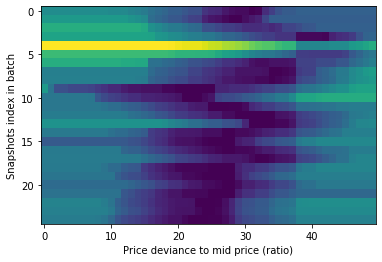

In [24]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure()

plt.xlabel('Price deviance to mid price (ratio)')
plt.ylabel('Snapshots index in batch')

#line, = ax.plot([], [], lw=2)
im=plt.imshow(all_input[0], aspect='auto')

# initialization function: plot the background of each frame
def init():
    im.set_data(im.set_data(all_input[0]))
    return [im]

# animation function.  This is called sequentially
def animate(i):
    a=im.get_array()
    a=all_input[i]    # exponential decay of the values
    im.set_array(a)
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate, 
                               frames = 10,
                               interval = 600, # in ms
                               )

In [25]:
HTML(anim.to_html5_video())

# Errors

In the examples above, all the generated images look nice, the prices in the order book increase as we dig deeper in the order book.


In [26]:
# Modelling

In [27]:
all_input.shape

(18886, 25, 50)

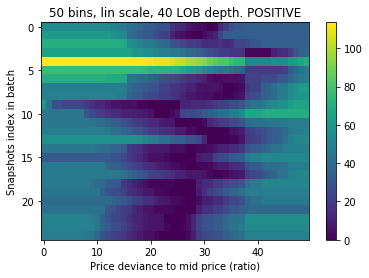

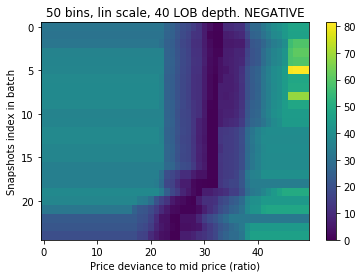

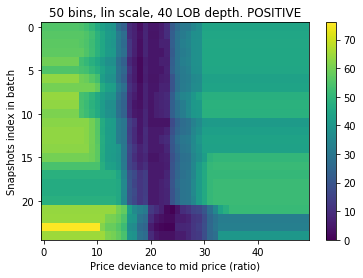

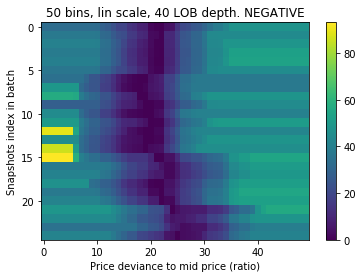

In [38]:
def get_label(in_label):
    if in_label == 0:
        return 'NEGATIVE'
    elif in_label == 1:
        return 'POSITIVE'

normaliser.generate_images()
    
i = 0
 
"""
for im_input, im_label in zip(all_input[::5100], all_labels[::5100]):    
    fig, ax = plt.subplots()

    plt.title(str(NR_OF_BINS) + ' bins, lin scale, ' + str(LOB_DEPTH) + ' LOB depth. ' + get_label(im_label))
    plt.imshow(im_input, aspect='auto')
    plt.xlabel('Price deviance to mid price (ratio)')
    plt.ylabel('Snapshots index in batch')
    plt.colorbar()
    plt.savefig('doc-figs/overfit-sample-' + str(i) + '.png')
    i += 1
    plt.show()
"""

In [ ]:
all_labels.reshape(len(all_labels), 1)
reshaped_input = all_input.reshape((all_input.shape[0], BATCH_SIZE, NR_OF_BINS, 1))


labels_categorical = to_categorical(all_labels)
print('Labels categorical shape: ', labels_categorical.shape)
print(labels_categorical[::10])

In [11]:
model = keras.Sequential([
    keras.layers.Conv2D(24, (5, 5), activation='tanh'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(24, (3, 3), activation='tanh'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1500, activation='tanh', bias_initializer='random_uniform'),
    keras.layers.Dense(500, activation='tanh', bias_initializer='random_uniform'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(2, activation='softmax', bias_initializer='random_uniform')
])
sgd = optimizers.sgd(lr=0.0005, decay=0.0001)
model.compile(optimizer=sgd,
              loss=keras.losses.mae,
              metrics=['categorical_accuracy'])

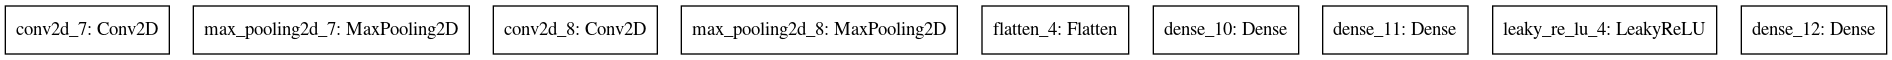

In [12]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='doc-figs/overfitting-model.png')

In [37]:
reshaped_input, labels_categorical = shuffle(reshaped_input[::5100], labels_categorical[::5100])

# training

model.fit(reshaped_input, labels_categorical,
          batch_size=4,
          epochs=130,
          verbose=1)

# evaluating and printing results
score = model.evaluate(reshaped_input[::5100], labels_categorical[::5100], verbose=0)
print(labels_categorical)
print(model.predict(reshaped_input))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Labels categorical shape:  (18886, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Epoch 1/130
4/4 [==============================] - 2s 382ms/step - loss: 0.4615 - categorical_accuracy: 0.5000
Epoch 2/130
4/4 [==============================] - 0s 4ms/step - loss: 0.4583 - categorical_accuracy: 0.5000
Epoch 3/130
4/4 [==============================] - 0s 3ms/step - loss: 0.4554 - categorical_accuracy: 0.5000
Epoch 4/130
4/4 [==============================] - 0s 4ms/step - loss: 0.4525 - categorical_accuracy: 0.5000
Epoch 5/130
4/4 [==============================] - 0s 4ms/step - loss: 0.4498 - categorical_accuracy: 0.5000
Epoch 6/130
4/4 [==============================] - 0s 4ms/step - loss: 0.4471 - categorical_accuracy: 0.7500
Epoch 7/130
4/4 [==============================] - 0s 4ms/step - loss: 0.4447 - categorical_accuracy: 0.7500
Epoch 8/130
4/4 [==============================] - 0s 4ms/step - loss: 0.4425 - categorical_accuracy: 0.7500
Epoch 9/130
4/4 [===========

Epoch 75/130
4/4 [==============================] - 0s 4ms/step - loss: 0.3332 - categorical_accuracy: 1.0000
Epoch 76/130
4/4 [==============================] - 0s 4ms/step - loss: 0.3318 - categorical_accuracy: 1.0000
Epoch 77/130
4/4 [==============================] - 0s 4ms/step - loss: 0.3305 - categorical_accuracy: 1.0000
Epoch 78/130
4/4 [==============================] - 0s 4ms/step - loss: 0.3292 - categorical_accuracy: 1.0000
Epoch 79/130
4/4 [==============================] - 0s 4ms/step - loss: 0.3280 - categorical_accuracy: 1.0000
Epoch 80/130
4/4 [==============================] - 0s 4ms/step - loss: 0.3267 - categorical_accuracy: 1.0000
Epoch 81/130
4/4 [==============================] - 0s 4ms/step - loss: 0.3255 - categorical_accuracy: 1.0000
Epoch 82/130
4/4 [==============================] - 0s 4ms/step - loss: 0.3242 - categorical_accuracy: 1.0000
Epoch 83/130
4/4 [==============================] - 0s 4ms/step - loss: 0.3229 - categorical_accuracy: 1.0000
Epoch 84/1

In [19]:
# %%


all_input = np.empty((0, BATCH_SIZE, NR_OF_BINS))
all_labels = np.empty((0))

for j in range(1, 27):
    curr_input = np.load(os.path.join(NORMALISATION_OUTPUT_FOLDER, 'linear-' + str(BIN_STEP) + '-' + str(NR_OF_BINS) + '_bins', 'XRP-USD/2020-04-04_1-normalised-' + str(j) + '.npy'))
    curr_mid_prices = np.load(os.path.join(NORMALISATION_OUTPUT_FOLDER, 'linear-' + str(BIN_STEP) + '-' + str(NR_OF_BINS) + '_bins', 'XRP-USD/2020-04-04_1-mid_price-' + str(j) + '.npy'))

    labels = []
    for i in range(0, len(curr_input) - LABELS_LOOKAHEAD):
        current_mid_price = curr_mid_prices[i]
        next_n_prices = curr_mid_prices[i + 1:i + 1 + LABELS_LOOKAHEAD]
        if current_mid_price < np.average(next_n_prices):
            labels.append(1)
        else:
            labels.append(0)
    labels = np.array(labels)
    reshaped_input = curr_input.reshape((curr_input.shape[0], BATCH_SIZE, NR_OF_BINS))[:-LABELS_LOOKAHEAD]
    all_input = np.concatenate([all_input, reshaped_input])
    all_labels = np.concatenate([all_labels, labels])